<h1>Astro 283 Homework 4</h1>
Bijan Pourhamzeh

<h3>Subtracting gaussian fit from the data</h3>
Below is the data subtracted by the single gaussian fit from the previous homework. Recall that the data was fit to a gaussian of the form

$$f_S(x,y,\vec{z}) = F\exp\left[-\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma_0^2}\right] + B$$

where $\vec{z} = (\sigma_0,x_0,y_0,F,B)$ is the vector of parameters we fit the data to via a least squares optimizer. We assume that the variance of the data is proportional to the data, so $\sigma_{x,y}^2 \propto D_{x,y}$.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from astropy.io import fits

In [2]:
#Import file and plot data

starfile = fits.open('hw3prob1-data.fits')
stardata = starfile[0].data
#plt.contourf(stardata)
#plt.colorbar()

In [3]:
#Gaussian fit from HW3

def gaussian_f(z,sig,x0,y0,F,B):
    #Model function to fit the data
    return F*np.exp(-1/(2*sig**2)*((z[0]-x0)**2+(z[1]-y0)**2)) + B

x_vals = np.linspace(0,stardata.shape[0]-1,stardata.shape[0])
y_vals = np.linspace(0,stardata.shape[1]-1,stardata.shape[1])
x_vals,y_vals = np.meshgrid(x_vals,y_vals)
ini_guess = (25.,125.,125.,80.,100.)
sigma_0 = np.sqrt(stardata)
popt_s, pcov_s = opt.curve_fit(gaussian_f, (x_vals.ravel(),y_vals.ravel()), stardata.ravel(), p0=ini_guess
                           , sigma=sigma_0.ravel())
print(popt_s)

[   7.12829056  125.97498933  132.4524456    26.19083029  133.01419728]


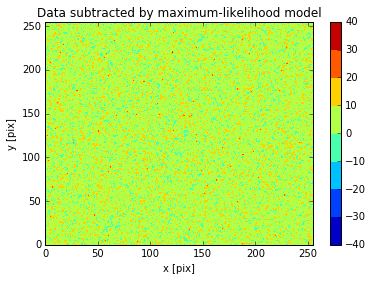

In [4]:
#Subtract Gaussian model from data

sig_s, x0_s, y0_s, F_s, B_s = popt_s
fit_nums = [[gaussian_f((xx,yy),sig_s,x0_s,y0_s,F_s,B_s) for xx in range(0,stardata.shape[0])] 
            for yy in range(0,stardata.shape[1])]
sub = stardata - fit_nums
plt.contourf(sub)
plt.colorbar()
plt.title('Data subtracted by maximum-likelihood model')
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')

<h3>Binary gaussian fit</h3>

Now we fit two gaussians to the data to test the hypothesis that there are two stars in the data. To do this, we fit the data to the function

$$f_B(x,y,\vec{z}) = F_1\exp\left[-\frac{(x-x_c-\frac{1}{2}r\cos\theta)^2 + (y-y_c-\frac{1}{2}r\sin\theta)^2}{2\sigma_0^2}\right] +  F_2\exp\left[-\frac{(x-x_c+\frac{1}{2}r\cos\theta)^2 + (y-y_c+\frac{1}{2}r\sin\theta)^2}{2\sigma_0^2}\right] + B$$

where $\vec{z} = (\sigma_0,x_c,y_c,r,\theta,F_1,F_2,B)$. The parameters $x_c,y_c$ are the center of the binary system, and $r,\theta$ are the length and angle with respect to $x$ of the line connecting the two stars. Here, we also assume that the variance of the data is proportional to the data, so $\sigma_{x,y} \propto D_{x,y}$. 

In [11]:
#Fit data to binary star model

def binary_gaussian_f(z,sig,xc,yc,r,theta,F1,F2,B):
    f1 = F1*np.exp(-0.5*((z[0]-xc-0.5*r*np.cos(theta))**2 + (z[1]-yc-0.5*r*np.sin(theta))**2)/sig**2)
    f2 = F2*np.exp(-0.5*((z[0]-xc+0.5*r*np.cos(theta))**2 + (z[1]-yc+0.5*r*np.sin(theta))**2)/sig**2)
    return f1 + f2 + B

ini_guess_b = [sig_s*0.5, x0_s, y0_s, 10., np.pi/4, F_s*0.5, F_s*0.5, B_s*0.5]
popt_b, pcov_b = opt.curve_fit(binary_gaussian_f, (x_vals.ravel(), y_vals.ravel()), stardata.ravel(), 
                           p0=ini_guess_b, sigma=sigma_0.ravel())
print(popt_b)
print(pcov_b[5:7,5:7])

[   6.11447468  128.39061119  134.79719517   11.94072753    0.77165792
   10.80667966   25.3423442   133.01264092]
[[ 1.95855897 -0.63010083]
 [-0.63010083  1.58251091]]


<h3>Model comparison</h3>

To compare the binary and single star models, we compute the ratio of the posteriors for each model, given by

$$\frac{P(B \mid \{D_{x,y}\})}{P(S \mid \{D_{x,y}\})} = \frac{P(\{D_{x,y}\}\mid B)P(B)}{P(\{D_{x,y}\}\mid S)P(S)}$$

We assume that the priors for each model are equal, so these terms cancel in the ratio. The likelihoods are given by (we write $M$ for a generic model and $\{\lambda\}$ for generic parameters)

\begin{eqnarray}
P(\{D_{x,y}\}\mid M) &=& \int P(\{D_{x,y}\},\{\lambda\}\mid M)d\{\lambda\}\\
&=& \int P(\{D_{x,y}\}\mid \{\lambda\}, M)P(\{\lambda\}\mid M)d\{\lambda\}
\end{eqnarray}

For the first term in the integrand, we make the approximation that the parameters are distributed as a gaussian, so we have

$$P(\{D_{x,y}\},\{\lambda\}\mid M) \approx P(\{D_{x,y}\},\{\lambda_0\}\mid M)\exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma^{-1}(\lambda-\lambda_0)\right]$$

where $\{\lambda_0\}$ is the collection of best-fit parameters, $\Sigma$ is the covariance matrix we get from the fitting. Therefore, we have

$$P(\{D_{x,y}\}\mid M) = P(\{D_{x,y}\},\{\lambda_0\}\mid M)\int \exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma^{-1}(\lambda-\lambda_0)\right]P(\{\lambda\}\mid M)d\{\lambda\}$$

We assume uniform priors for the parameters, which means

$$P(\{\lambda\}\mid M) = \prod_i P(\lambda_i\mid M) = \prod_i\frac{1}{\lambda_i^{\text{max}} - \lambda_i^{\text{min}}}$$

This means that we can pull this term out of the integral, leaving us with a multivariate gaussian integral. This can be done easily, and gives

\begin{eqnarray}
P(\{D_{x,y}\}\mid M) &=& P(\{D_{x,y}\},\{\lambda_0\}\mid M)\prod_i\frac{1}{\lambda_i^{\text{max}} - \lambda_i^{\text{min}}}\int \exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma^{-1}(\lambda-\lambda_0)\right]d\{\lambda\}\\
&=& P(\{D_{x,y}\},\{\lambda_0\}\mid M)\prod_i\frac{1}{\lambda_i^{\text{max}} - \lambda_i^{\text{min}}} \sqrt{(2\pi)^{n}\det\Sigma}
\end{eqnarray}

where $n$ is the number of parameters.

Plugging this formula into our comparison, we first note that there are 5 parameters for the single star model and 8 for the binary star model. For the priors, we take the position parameters to be anywhere in the grid, so $x^{\text{max}} - x^{\text{min}} = 256\text{ pix}$ and same for $y,r$. For $\sigma$, we assume both models have the same range, so they cancel when we take the ratio. For $\theta$, we assume it can be in the range $0\ldots\pi$. For the background, $B$, we take the same range for the two models. For the fluxes, we take $F^{\text{max}} - F^{\text{min}} = 300\text{ DN}$ for both models. Putting this all together, we have

$$\frac{P(B \mid \{D_{x,y}\})}{P(S \mid \{D_{x,y}\})} = \frac{(2\pi)^{3/2}}{300\cdot256\cdot\pi}\sqrt{\frac{\det\Sigma_B}{\det\Sigma_S}}\exp\left[-\frac{1}{2}(\chi_B^2-\chi_S^2)\right]$$

where the second factor comes from the uniform priors and

$$\chi_M^2 = \sum_{x,y}\frac{(D_{x,y}-f_M(x,y,\vec{z}))^2}{D_{x,y}}$$

for each model $M=B,S$.

Below is the result of computing this ratio for the parameters we found. 

In [6]:
F_max = 300
r_max = stardata.shape[0]
det_cov_b = np.linalg.det(pcov_b)
det_cov_s = np.linalg.det(pcov_s)
sig_b, x0_b, y0_b, r_b, theta_b, F1_b, F2_b, B_b = popt_b

chi2_b = 0
for xx in range(0,stardata.shape[0]):
    for yy in range(0,stardata.shape[1]):
        res = stardata[xx,yy] - binary_gaussian_f((xx,yy),sig_b,x0_b,y0_b,r_b,theta_b,F1_b,F2_b,B_b)
        chi2_b += res**2/abs(stardata[xx,yy])
print(chi2_b)

chi2_s = 0
for xx in range(0,stardata.shape[0]):
    for yy in range(0,stardata.shape[1]):
        res = stardata[xx,yy] - gaussian_f((xx,yy),sig_s,x0_s,y0_s,F_s,B_s)
        chi2_s += res**2/abs(stardata[xx,yy])
print(chi2_s)

num_den = np.exp(-0.5*(chi2_b-chi2_s))
print(num_den)
param_diff = len(pcov_b)-len(pcov_s)
ratio = np.power(2*np.pi,0.5*param_diff)/(F_max*r_max*np.pi)*np.sqrt(det_cov_b/det_cov_s)*num_den
print(ratio)

22578.6024366
22514.1640311
1.0171336721e-14
3.070519317e-20


<h3>Joint distribution for star fluxes in the binary model</h3>

Assuming the joint distribution for the fluxes of star 1 and 2 is gaussian (this follows from the gaussian approximation of the distribution of the best-fit parameters and integrating out the unwanted parameters. The result is still a gaussian), we have

$$P(F_1,F_2\mid \{D_{x,y}\}) = \frac{1}{2\pi\sqrt{\det\Sigma_F}}\exp\left[-\frac{1}{2}(F-F_0)^T\Sigma_F^{-1}(F-F_0)\right]$$

where

$$F_0 = \left(
\begin{array}{cc}
10.8\\
25.3
\end{array}
\right)$$

are the best fit parameters for the fluxes of star 1 and star 2 in DN, respectively, and the covariance matrix is

$$\Sigma_F = \left(
\begin{array}{cc}
1.96 & -0.63\\
-0.63 & 1.58
\end{array}
\right)$$

which is obtained from the $2\times 2$ block of $\Sigma_B$ corresponding to the flux parameters. 

<h3> Joint distribution of $(r,\theta)$ in the binary model</h3>

Similar to the above discussion, the joint distribution for the position $\vec{r}=(r,\theta)$ of the stars in the binary model is given by

$$P(r,\theta\mid \{D_{x,y}\}) = \frac{1}{2\pi\sqrt{\det\Sigma_\vec{r}}}\exp\left[-\frac{1}{2}(\vec{r}-\vec{r}_0)^T\Sigma_\vec{r}(\vec{r}-\vec{r}_0)\right]$$

where

$$\vec{r}_0 = \left(
\begin{array}{cc}
11.9\\
0.77
\end{array}
\right)$$

are the best fit parameters for relative positions of the stars, and the covariance matrix is

$$\Sigma_\vec{r} = \left(
\begin{array}{cc}
0.46 & -4.73\times 10^{-5}\\
-4.73\times 10^{-5} & 3.20\times10^{-3}
\end{array}
\right)$$

which is obtained from the $2\times 2$ block of $\Sigma_B$ corresponding to $r,\theta$. Below is a plot of this distribution. 

(100, 256)


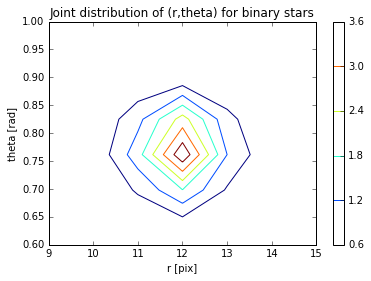

In [10]:
theta = np.linspace(0,2*np.pi,100)
r = np.linspace(0,stardata.shape[0]-1,stardata.shape[0])

cov_r = pcov_b[3:5,3:5]
det_covr = np.linalg.det(cov_r)
inv_covr = np.linalg.inv(cov_r)

joint_rt = np.array([[1/(2*np.pi*np.sqrt(det_covr))*np.exp(-0.5*float(np.dot(np.dot(np.transpose(np.array([[rr-r_b],
                                                                                       [tt-theta_b]])),
                                                       inv_covr),np.array([[rr-r_b],[tt-theta_b]]))))
          for rr in r] for tt in theta])
print(joint_rt.shape)
#plt.contourf(stardata)
#
#plt.rc('text', usetex = True)
#plt.rc('font', family='serif')
plt.contour(r, theta, joint_rt)
plt.colorbar()
plt.axis([9,15,0.6,1.])
plt.xlabel('r [pix]')
plt.ylabel('theta [rad]')
plt.title('Joint distribution of (r,theta) for binary stars')